In [150]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.autograd import Variable
from torchvision.datasets import ImageFolder
from torch import optim
import torch.nn.functional as F
import random
from torchvision import transforms
import PIL
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from mediumdataset import SiameseNetworkDataset

In [143]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.Dropout2d(p=.2),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(401408, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5)
        )

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2
    
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive
    
def confusion_matrix(y_pred, y_true, threshold=0.5):
    y_pred, y_true = y_pred.view(-1), y_true.view(-1).int()
    y_pred = rounding(y_pred, threshold).int()
#     fn = (1-y_pred == y_true).sum()
#     ap = (y_pred == y_true).sum()
#     an = (y_pred != y_true).sum()
#     fp = (y_pred == 1-y_true).sum()
#     fn,fp,ap,an = fn.item(),fp.item(),ap.item(),an.item()
#     error = (fn + fp) / (fp+fn+ap+an) * 100
#     accuracy = (ap+an) / (fp+fn+ap+an) * 100
    corrects = y_true == y_pred
    accuracy = torch.mean(corrects.type(torch.FloatTensor))
    return accuracy, 1-accuracy #accuracy, errors

def rounding(val, threshold=0.5):
    return val > threshold


In [17]:
trainfolder = ImageFolder('dataset/train/facescrub')
validfolder = ImageFolder('dataset/valid/facescrub')

trfm_valid = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

trfm_train = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

target_trfrm = transforms.Compose([
    lambda x: [x],
    torch.Tensor
])

trainset = SiameseNetworkDataset(trainfolder, transform=trfm_train, target_transform=target_trfrm, should_invert=False)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
validset = SiameseNetworkDataset(validfolder, transform=trfm_valid, target_transform=target_trfrm, should_invert=False)
validloader = DataLoader(validset, batch_size=32, shuffle=True)
len(trainloader), len(validloader)

(230, 97)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = SiameseNetwork().to(device)
net = nn.DataParallel(net)
criterion = ContrastiveLoss().to(device)
optimizer = optim.Adam(net.parameters(),lr = 0.0005)

counter = []
loss_history = [] 

In [21]:
iteration_number= 0

for epoch in range(0,10):
    for i, data in enumerate(trainloader,0):
        img0, img1 , label = map(lambda i: i.to(device), data)
        output1,output2 = net(img0,img1)
        optimizer.zero_grad()
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

Epoch number 0
 Current loss 159.10256958007812

Epoch number 0
 Current loss 21.58745574951172

Epoch number 0
 Current loss 18.343406677246094

Epoch number 0
 Current loss 14.140998840332031

Epoch number 0
 Current loss 5.1483306884765625

Epoch number 0
 Current loss 3.0319526195526123

Epoch number 0
 Current loss 2.272136688232422

Epoch number 0
 Current loss 2.348996639251709

Epoch number 0
 Current loss 2.1955032348632812

Epoch number 0
 Current loss 1.7617130279541016

Epoch number 0
 Current loss 1.687007188796997

Epoch number 0
 Current loss 1.962514877319336

Epoch number 0
 Current loss 1.2902778387069702

Epoch number 0
 Current loss 1.303011178970337

Epoch number 0
 Current loss 1.4869194030761719

Epoch number 0
 Current loss 1.557818055152893

Epoch number 0
 Current loss 1.3243848085403442

Epoch number 0
 Current loss 3.1399264335632324

Epoch number 0
 Current loss 1.4079254865646362

Epoch number 0
 Current loss 1.3779977560043335

Epoch number 0
 Current los

In [121]:
def imshow(inp, title=None, nth=1, rows=1, cols=1):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.subplot(rows, cols, nth)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [148]:
validset = SiameseNetworkDataset(validfolder, transform=trfm_valid, target_transform=target_trfrm, should_invert=False)
validloader = DataLoader(validset, batch_size=64, shuffle=True)

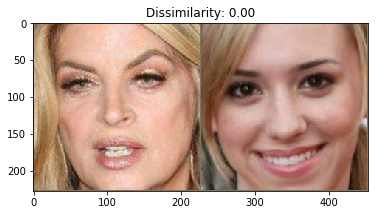

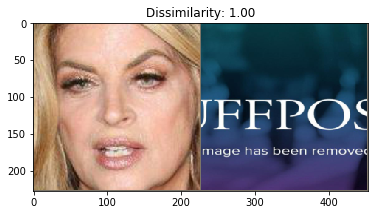

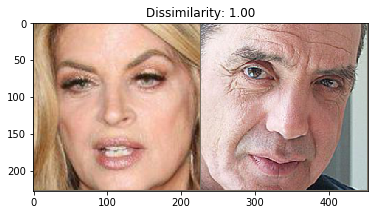

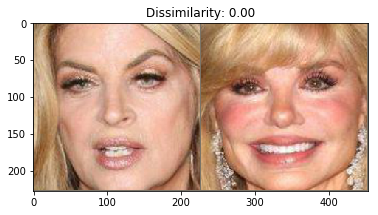

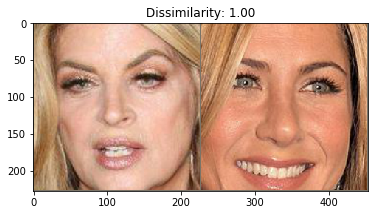

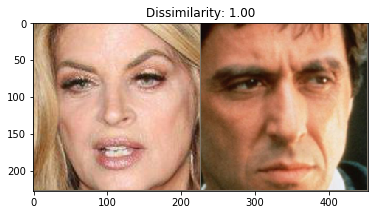

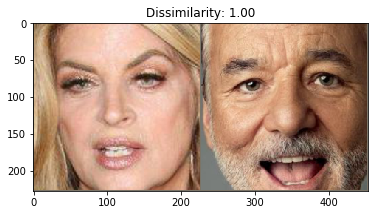

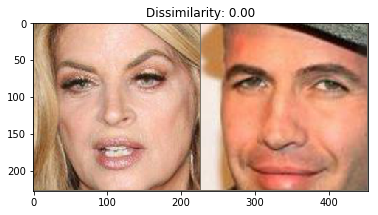

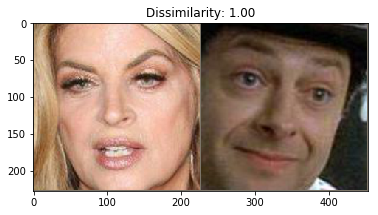

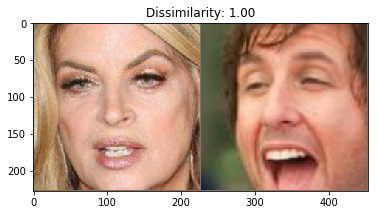

In [122]:
dataiter = iter(validloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2) > 0.5
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

In [149]:
net.eval()
len_valid = len(validloader)
laccuracy = []
progress = tqdm(enumerate(validloader, 1))
with torch.no_grad():
    for idx, (img1,img2,label) in progress:
        img1 = img1.to(device)
        img2 = img2.to(device)
        label = label.to(device)
        out1, out2 = net.forward(img1,img2)
        predicted_label = F.pairwise_distance(out1, out2)


        acc, err = confusion_matrix(predicted_label, label, threshold=0.5)
        progress.set_description(f'Val acc {idx}/{len_valid}: {acc.item():.3f}')
        laccuracy.append(acc.item())
    
print(f"Avg valid accuracy: {sum(laccuracy)/len(laccuracy)}")
# y_true = np.array(list(itertools.chain(*labels)))
# y_pred = np.array(list(itertools.chain(*preds)))
# tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
# total = tn+tp+fp+fn
# print(f'Predicted true and actually true: {tp}'
#       f'\nPredicted false and actually false: {tn}'
#       f'\nPredicted true but actually false: {fp}'
#       f'\nPredicted false but actually true: {fn}'
#       f'\nTotal correct predictions: {tp+tn} ({(tp+tn)/total*100:.2f})'
#       f'\nTotal wrong predictions: {fn+fp} ({(fn+fp)/total*100:.2f})'
#       f'\nTotal: ({total})')

Avg valid accuracy: 0.4854542783328465
